# Advent of Code

In [87]:
from matplotlib import pyplot as plt, animation
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

%matplotlib notebook

# Upute za preuzimanje zadataka

Posjetiti stranicu *[Advent of Code](https://adventofcode.com)*. Na toj stranici napraviti acconut (moze se koristiti github/email) i kopirati svoj session. Pozvati fju get_aoc_input sa session_str jednakim session-u i danom i godinom zadatka.

In [88]:
session = '53616c7465645f5fa84cdf4fd1e667823de36970c380c49a1373a1ac0d5a4ddf77aeb87eda22f992bac9a4e24fa8295f06c385916e074b59f6ba4ee8e53b2612'

In [89]:
import requests
import os

def get_aoc_input(session_str, day, year, return_output=False):
    
    if os.path.exists(f'./{year}_{day}_input.txt'):
        with open(f'{year}_{day}_input.txt') as f:
            text = [x.strip() for x in f.readlines()]
        if return_output: return text
    else:
        response = requests.get(
            f'https://adventofcode.com/{year}/day/{day}/input',
            headers={'cookie':f'session={session_str}'}
        )
    
        try:
            with open(f'{year}_{day}_input.txt', 'w') as f:
                f.write(response.text.strip())
            if return_output: return [x.strip() for x in response.text.strip().split('\n')]
        except Exception as e:
            print(f'Error: {e.args}')
            return None

## Experimental Emergency Teleportation
*[Link na zadatak](https://adventofcode.com/2018/day/23)*

In [90]:
import re
from collections import Counter

def parse_line(line):
    return tuple(map(int, re.match(r'pos=<(-?\d+),(-?\d+),(-?\d+)>, r=(\d+)', line).groups()))

def manh_dist(point1, point2):
    return sum(abs(point1[i] - point2[i]) for i in range(3))

inlist = get_aoc_input(session, 23, 2018, return_output=True)
inputs = [parse_line(line) for line in inlist]
c = Counter()
for n1 in inputs:
    for n2 in inputs:
        if manh_dist(n1,n2) <= n1[-1]:
            c[n1] += manh_dist(n1,n2) <= n1[-1]

n = sorted(c.keys(), key=lambda x: x[-1], reverse=True)[0]
print(c[n])

420


In [91]:
from z3 import *

def zabs(x):
    return If(x >= 0,x,-x)

(x,y,z) = (Int('x'),Int('y'),Int('z'))
in_ranges = [Int(f'in_range_{i}') for i in range(len(inputs))]
range_count = Int('sum')
dist_from_zero = Int('dist')

o = Optimize()
for i in range(len(inputs)):
    nx,ny,nz,nr = inputs[i]
    o.add(in_ranges[i] == If(zabs(x-nx) + zabs(y-ny) + zabs(z-nz) <= nr, 1, 0))   
o.add(range_count == sum(in_ranges))
o.add(dist_from_zero == zabs(x) + zabs(y) + zabs(z))

In [92]:
h1 = o.maximize(range_count)
h2 = o.minimize(dist_from_zero)
print(o.check())
print(o.lower(h2), o.upper(h2))

unknown
-1*oo 429926391


## Lanternfish

*[Link na zadatak](https://adventofcode.com/2021/day/6)*

In [93]:
from collections import deque
import re
import itertools as it

Dohvatimo input za zadatak i pocnimo :)

In [94]:
get_aoc_input(session, 6, 2021)

Vidimo da je input jako lijepo formatiran (ako se radi u python-u ;), to se lako obradi uz malo `str`/`np.loadtxt` magije

### Rjesenje pomocu numpy-a

In [95]:
lines = np.loadtxt('2021_6_input.txt', delimiter=',', dtype="uint32")
fish_timer = np.zeros(9)
time, count = np.unique(lines, return_counts=True)
fish_timer[time] = count

In [96]:
def memoize_numpy(fish_timer, days):
    gen = np.copy(fish_timer)
    for _ in range(days):
        gen[7] += gen[0]
        gen = np.roll(gen, -1)
    return sum(gen)

In [97]:
print(memoize_numpy(fish_timer, 80))
print(memoize_numpy(fish_timer, 256))

362346.0
1639643057051.0


<IPython.core.display.Javascript object>


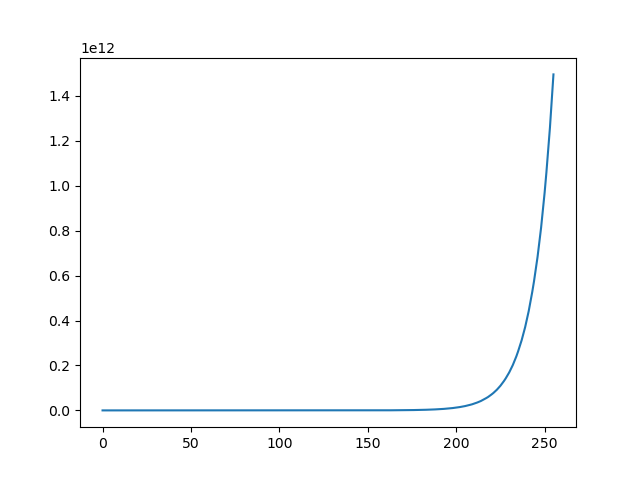

In [98]:
def generator(fish_timer, days):
    for i in range(days):
        yield memoize_numpy(fish_timer, i)

y = [x for x in generator(fish_timer, 256)]

fig, ax = plt.subplots()
ax.plot(y)
plt.show()

### Rjesenje pomocu vulgaris python-a :)

In [99]:
with open('2021_6_input.txt') as f:
    inlist = list(map(int, f.readline().strip().split(',')))
d = deque([0 for _ in range(9)])
for num in inlist:
    d[num] += 1

In [100]:
def memoize_pure_python(deq, days):
    d = deque([x for x in deq])
    for _ in range(days):
        d[7] += d[0]
        d.rotate(-1)
    return sum(d)

In [101]:
print(memoize_pure_python(d, 80))
print(memoize_pure_python(d, 256))

362346
1639643057051


## Smoke Basin

*[Link na zadatak](https://adventofcode.com/2021/day/9)*

In [102]:
inlist = get_aoc_input(session, 9, 2021, return_output=True)
matrix = [[int(x) for x in line] for line in inlist]
matrixes = np.array([[[int(x) for x in line] for line in inlist]])

In [103]:
def check_low_spot(i,j,inlist,matrix):
    ok = True
    for (x,y) in [(1,0), (0,1), (-1,0), (0,-1)]:
        if -1 < y + j < len(inlist) and -1 < x + i < len(line):
            ok &= int(inlist[y+j][x+i]) > int(l)
    if ok:
        matrix[j][i] = 0
        return matrix, 1+int(l)
    else:
        matrix[j][i] = 6 if matrix[j][i] != 9 else 9
        return None, None

In [104]:
lows,s = [],0
for j,line in enumerate(inlist):
    for i,l in enumerate(line):
        m, n = check_low_spot(i,j,inlist,matrix)
        if m is not None:
            s += n
            lows.append((i,j))
            matrixes = np.append(matrixes, [m], axis=0)
print(s)

558


In [105]:
def basin_size(x,y,inlist):
    seen = set()
    Q = [(x,y)]
    size = 0
    while len(Q) > 0:
        curr = Q.pop(0)
        curx, cury = curr
        if curr in seen:
            continue
        seen.add(curr)
        if 0 <= cury < len(inlist) and 0 <= curx < len(inlist[0]):
            if int(inlist[cury][curx]) != 9:
                size += 1
                Q += [(curx+1,cury), (curx-1,cury), (curx,cury+1), (curx,cury-1)]
    return size

In [106]:
basins = []
for (x,y) in lows:
    basins.append(basin_size(x,y,inlist))
basins.sort()
print(f'Size of the largest three basins: {basins[-1]}, {basins[-2]}, {basins[-3]}')
print(f'Those numbers multiplied: {basins[-1] * basins[-2] * basins[-3]}')

Size of the largest three basins: 101, 94, 93
Those numbers multiplied: 882942


<IPython.core.display.Javascript object>


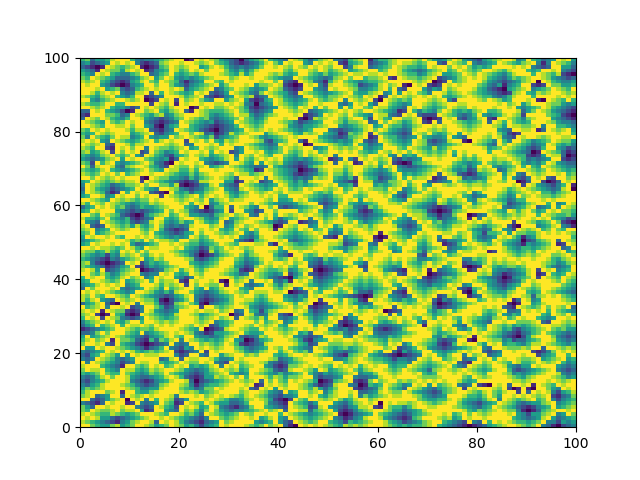

In [107]:
fig, ax = plt.subplots()
cax = ax.pcolormesh(matrixes[0, :, :])

In [108]:
def basin_animate(i):
    cax.set_array(matrixes[i, :, :])
    return cax

anim = animation.FuncAnimation(fig, basin_animate, interval=100, frames=matrixes.shape[0] - 1)
plt.show()

## Jurassic Jigsaw

In [174]:
get_aoc_input(session, 20, 2020)

with open('2020_20_input.txt') as f:
    tiles = {
        int((line := tile.split('\n'))[0].split()[1][:-1]) : np.array([[int(x) for x in y] for y in line[1:]])
        for tile in f.read().replace('.','0').replace('#','1').split('\n\n')
    }

In [175]:
from functools import reduce

edges = {
    k : set.union(*[{tuple(edge), tuple(reversed(edge))} for edge in [v[0], v[-1], v[:,0], v[:,-1]]])
    for k, v in tiles.items()
}
neighbors = {
    k1 : ({k2 for k2, v2 in edges.items() if v1 & v2} - {k1}) for k1,v1 in edges.items()
}
corners = [k for k, v in neighbors.items() if len(v) == 2]

print(reduce(lambda a,b: a * b, corners))

17148689442341


In [176]:
def rotations(tile):
    for _ in range(2):
        for _ in range(4):
            tile = np.rot90(tile)
            yield tile
        tile = np.flip(tile,0)

In [177]:
current = corners[0]
reverse = False
tiles[current] = next(
    tile for tile in rotations(tiles[current]) 
    if {tuple(tile[-1]), tuple(tile[:,-1])}.issubset(
        set.union(*[edges[k] for k in neighbors[current]])
    )
)
chart = []
chart_row = [tiles[current][1:-1,1:-1]]
chart_with_edges = []
chart_row_with_edges = [tiles[current]]

In [178]:
def find_next_tile(current, current_edge, reverse, row):
    next_tile = [k for k in neighbors[current] if tuple(current_edge) in edges[k]]
    if len(next_tile) > 0:
        tiles[next_tile[0]] = [
            tile for tile in rotations(tiles[next_tile[0]]) 
            if tuple(current_edge) == (tuple(tile[:,-int(reverse)]) if row else tuple(tile[0]))
        ][0]
        return next_tile[0]
    return None

In [179]:
def get_next_tile(current, chart, chart_row, cwe, crwe, reverse, row=True):
    next_tile_id = find_next_tile(current, tiles[current][:,-(not reverse)] if row else tiles[current][-1], reverse, row)
    if next_tile_id:
        current = next_tile_id
        chart_row += [tiles[current][1:-1,1:-1]]
        crwe += [tiles[current]]
    else:
        if len(chart_row) == 0: return next_tile_id
        chart += [np.hstack(chart_row)] if not reverse else [np.hstack(chart_row[::-1])]
        cwe += [np.hstack(crwe)] if not reverse else [np.hstack(crwe[::-1])]
        chart_row.clear()
        crwe.clear()
    return next_tile_id

<IPython.core.display.Javascript object>


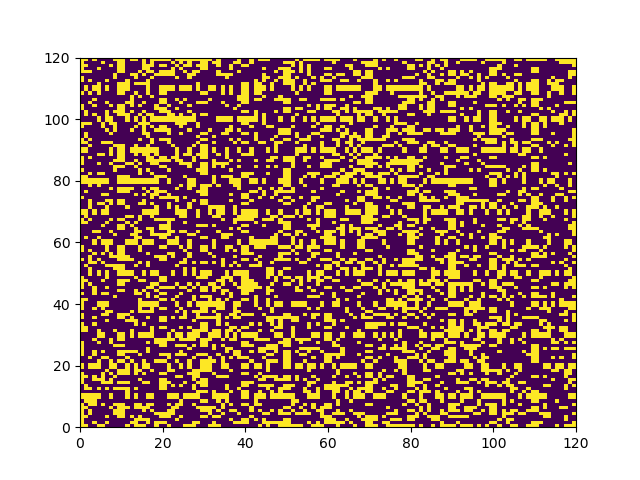

In [180]:
while current:
    next_tile_id = get_next_tile(current, chart, chart_row, chart_with_edges, chart_row_with_edges, reverse)
    if next_tile_id is None:
        reverse = not reverse
        current = get_next_tile(current, chart, chart_row, chart_with_edges, chart_row_with_edges, reverse, row=False)
    else:
        current = next_tile_id
        
chart = np.vstack(chart)
chart_with_edges = np.vstack(chart_with_edges)
fig, ax = plt.subplots()
cax = ax.pcolormesh(chart_with_edges)

In [181]:
nessie = np.array([[int(x) for x in y] for y in ('''
                  # 
#    ##    ##    ###
 #  #  #  #  #  #   
'''.replace(' ', '0').replace('#','1').split('\n')[1:-1])])

def scan(chart, nessie):
    nessies = 0
    for i in range(len(chart) - len(nessie)):
        for j in range(len(chart[0]) - len(nessie[0])):
            area = (chart[i : i + len(nessie), j : j + len(nessie[0])] + nessie)
            if len(area[area == 2]) == 15:
                for k in range(i, i + len(nessie)):
                    for l in range(j, j + len(nessie[0])):
                        if nessie[k - i][l - j] == 1: chart[k][l] = 10
                nessies += 1
    return nessies

29
2009


<IPython.core.display.Javascript object>


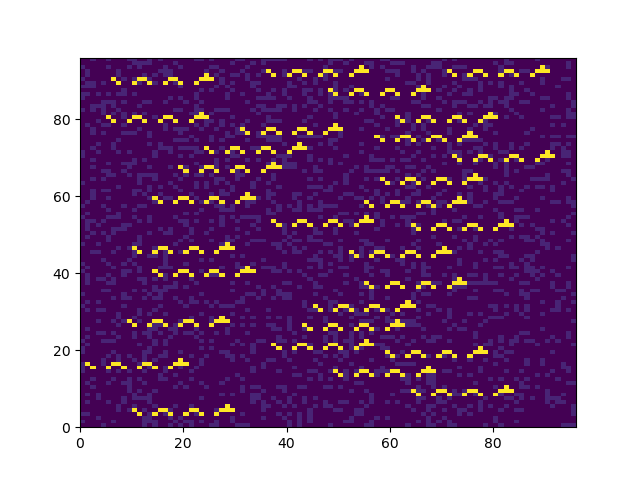

In [182]:
for rot in rotations(chart):
    if (nessies := scan(rot, nessie)) > 0:
        print(nessies)
        print(sum(chart[chart == 1]))
        rot = np.fliplr(np.flip(rot))
        fig, ax = plt.subplots()
        cax = ax.pcolormesh(rot)
        break

# Sea Cucumber

In [216]:
from collections import defaultdict

inlist = get_aoc_input(session, 25, 2021, return_output=True)
d = defaultdict(str)
for i,line in enumerate(inlist):
    for j,char in enumerate(line):
        d[(i,j)] = char
dir_map = {'>' : 4, 'v' : 7, '.' : 0}
cucumber_matrix = [[dir_map[x] for x in line] for line in inlist]
move_map = {'>' : (0,1), 'v' : (1,0)}
len_row, len_col = len(inlist), len(inlist[0])

In [217]:
def move_cucumber(direction, d, dd, len_row, len_col, cucumber_matrix, dir_map, move_map):
    moved = False
    for i in range(len_row):
        for j in range(len_col):
            k,l = (i + move_map[direction][0]) % len_row, (j + move_map[direction][1]) % len_col
            if d[(i,j)] == direction and d[(k,l)] == '.':
                dd[(i,j)] = '.'
                dd[(k,l)] = direction
                cucumber_matrix[i][j] = 0
                cucumber_matrix[k][l] = dir_map[direction]
                moved = True
    return dd, moved

In [218]:
step = 0
matrix_list = np.array([[[dir_map[x] for x in line] for line in inlist]])
while True:
    dd = {k : v for k,v in d.items()}
    dd, moved = move_cucumber('>', d, dd, len_row, len_col, cucumber_matrix, dir_map, move_map)
    matrix_list = np.append(matrix_list, [cucumber_matrix], axis=0)
    d = {k : v for k,v in dd.items()}
    d, moved2 = move_cucumber('v', dd, d, len_row, len_col, cucumber_matrix, dir_map, move_map)
    matrix_list = np.append(matrix_list, [cucumber_matrix], axis=0)
    step += 1
    if not moved and not moved2: break
print(step)

518


<IPython.core.display.Javascript object>


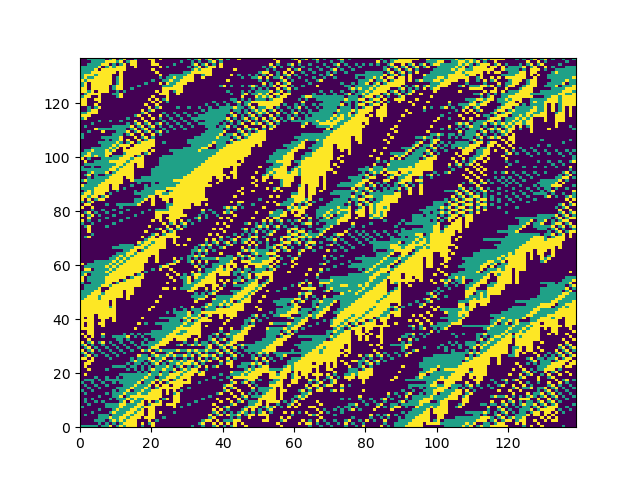

In [219]:
def cucumber_animate(i):
    cax.set_array(matrix_list[i, :, :])
    return cax

fig, ax = plt.subplots()
cax = ax.pcolormesh(matrix_list[0, :, :])

anim = animation.FuncAnimation(fig, cucumber_animate, interval=50, frames=matrix_list.shape[0] - 1)
plt.show()